In [1]:
#connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import json
f = open('/content/gdrive/MyDrive/capstone/code/sherlock_train_v1_1.json')
data = json.load(f)



In [54]:
d = data[1002]
d


{'inputs': {'image': {'url': 'https://cs.stanford.edu/people/rak248/VG_100K_2/2392963.jpg',
   'width': 500,
   'height': 375},
  'bboxes': [{'height': 96, 'width': 189, 'left': 134, 'top': 134}],
  'clue': 'pan of bread in oven',
  'confidence': 3.0,
  'obs_idx': 0},
 'targets': {'inference': 'the bread is cooking'},
 'instance_id': 'e04c567453ae3884bc61c9de93eed0d4'}

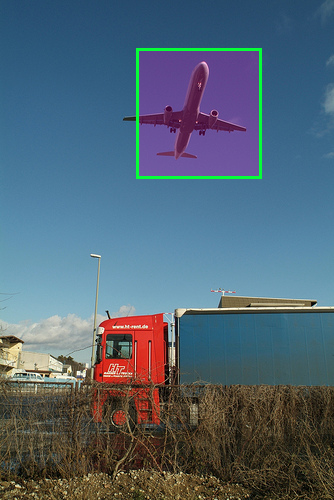

In [49]:
from PIL import Image, ImageDraw

def hide_region(image, bboxes):
    image = image.convert('RGBA')
    overlay = Image.new('RGBA', image.size, '#00000000')
    draw = ImageDraw.Draw(overlay, 'RGBA')

    for bbox in bboxes:
        x = bbox['left']
        y = bbox['top']
        draw.rectangle([(x, y), (x+bbox['width'], y+bbox['height'])],fill='#ff05cd3c', outline='#05ff37ff', width=3)

    image = Image.alpha_composite(image, overlay)

    return image

image = Image.open("/content/gdrive/MyDrive/capstone/images/VG_100K/2319686.jpg")

image = hide_region(image,d['inputs']['bboxes'])
image

# **Detectron**


## Set Up


In [6]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 32.1 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=15bfc66515ee5d393be2dd70584cf475bc1c297c54207aebc00c456ca7e28ced
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/

In [7]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.12 ; cuda:  cu113
detectron2: 0.6


In [8]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Run It

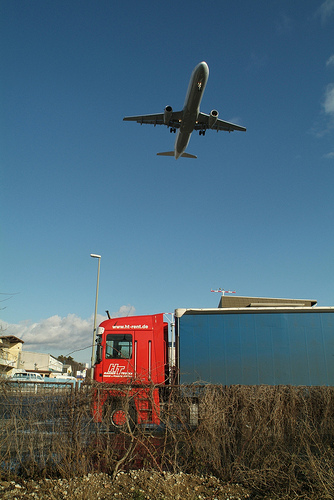

In [36]:
#!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("/content/gdrive/MyDrive/capstone/images/VG_100K/2319686.jpg")
cv2_imshow(im)

In [37]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [38]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([4, 7, 7, 2], device='cuda:0')
Boxes(tensor([[125.8720,  62.9103, 245.7075, 160.8425],
        [ 96.1662, 295.9993, 331.0227, 441.9749],
        [ 89.1691, 312.0900, 173.5767, 434.6581],
        [  8.8771, 372.5162,  44.7130, 382.1209]], device='cuda:0'))


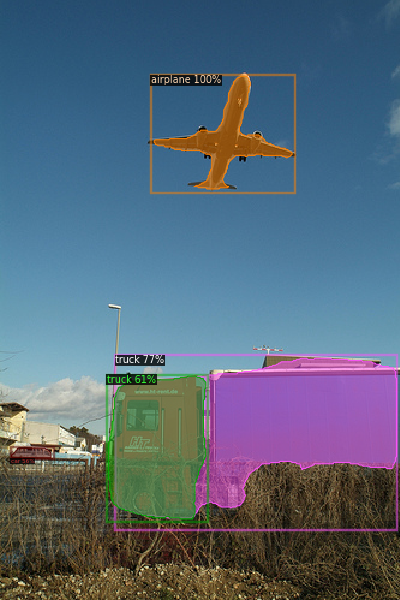

In [39]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])